# VGG复现实验

## 实验目的
试编程实现VGG网络。我们这里选择VGG-16。

## 实验环境
PyTorch 2.4.0
CUDA 12.4

## 实验方法

### 选择深度学习框架
选择PyTorch作为本次实验的深度学习框架，主要是因为它提供了动态计算图的支持，这使得代码调试更加直观且易于理解。PyTorch拥有强大的社区支持和丰富的资源，这对于解决开发过程中遇到的问题非常有帮助。此外，PyTorch与CUDA的集成非常紧密，能够充分利用GPU加速计算，这对于拥有如3060 Laptop GPU这样支持CUDA操作的显卡的设备来说，意味着可以显著提升训练速度和效率。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

### 数据集  

ImageNet-1k 包含 1000 个类别的图像数据，每个类别代表现实世界中不同的物体或概念，如猫、狗、鸟等。在 ImageNet-1k 中，总共包含约 128 万张训练图像、5 万张验证图像和 10 万张测试图像。它是计算机视觉领域最常用的数据集之一，并被广泛用于深度神经网络模型（如 AlexNet、VGG、ResNet 等）的训练和评测。此外，ImageNet-1k 数据集常在 ILSVRC（ImageNet Large Scale Visual Recognition Challenge）中用于模型性能评测。

由于 ImageNet-1k 的总大小超过了100G，使用个人电脑很难在较短时间内完成下载和训练，我们使用 Tiny ImageNet 替代。Tiny ImageNet 是 ImageNet 数据集的简化版本，包含 200 个类别的 110,000 张图像 (100,000 张训练集与 10,000 张测试集)，每个类别有 500 张训练图像、50 张验证图像、以及 50 张测试图像。每张图像的尺寸为 64×64 像素。大部分图像为 RGB，少部分为灰度图，所以需要在预处理中统一格式。与 ImageNet-1k 相比，它更小、更易于管理，并且无需较大的计算资源，我们选择Tiny ImageNet 作为本次实验的数据集。相似地，Tiny ImageNet 可以通过`zh-plus/tiny-imagenet` 来加载。

预处理通常包括使用 `transforms` 进行数据增强以及标准化操作，将图像数据归一化到特定的均值和方差范围（例如：`mean=[0.485, 0.456, 0.406]` 和 `std=[0.229, 0.224, 0.225]`），并将其转换为 PyTorch 张量。在实验过程中，数据集应被划分为训练集、验证集和测试集三部分。Tiny ImageNet 提供了独立的验证集（10,000 张图像），然而因为比赛需求所以没有提供测试集，测试集需要从验证集中单独划分，这可以通过 `torch.utils.data` 中的 `random_split` 函数来实现，比例可以选取为 8:2。

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
from datasets import load_dataset

# 确保所有图像是 RGB 格式
def ensure_rgb(image):
    if image.mode == 'L':
        return image.convert('RGB')
    return image

# 自定义 transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像尺寸为 64x64
    transforms.Lambda(ensure_rgb),  # 确保所有图像都是 RGB
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 归一化
                         std=[0.229, 0.224, 0.225])
])

# 加载数据集
dataset = load_dataset('zh-plus/tiny-imagenet')

# 对训练集和验证集应用预处理
def transform_dataset(sample):
    return {
        'image': transform(sample['image']),  # 图像在 CPU 上转换为张量
        'label': torch.tensor(sample['label'], dtype=torch.long)  # 确保标签是长整型
    }

# 应用 transform
train_dataset = dataset['train'].map(transform_dataset, batched=False)
val_dataset = dataset['valid'].map(transform_dataset, batched=False)

# 转化为Torch Tensor
train_dataset.set_format(type='torch', columns=['image', 'label'])
val_dataset.set_format(type='torch', columns=['image', 'label'])

# 设置验证集与测试集的划分比例
val_size = int(0.8 * len(val_dataset))  # 80% 的数据作为验证集
test_size = len(val_dataset) - val_size  # 20% 的数据作为测试集

# 使用 random_split 划分验证集和测试集
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

# 输出数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

训练集大小: 100000
验证集大小: 8000
测试集大小: 2000


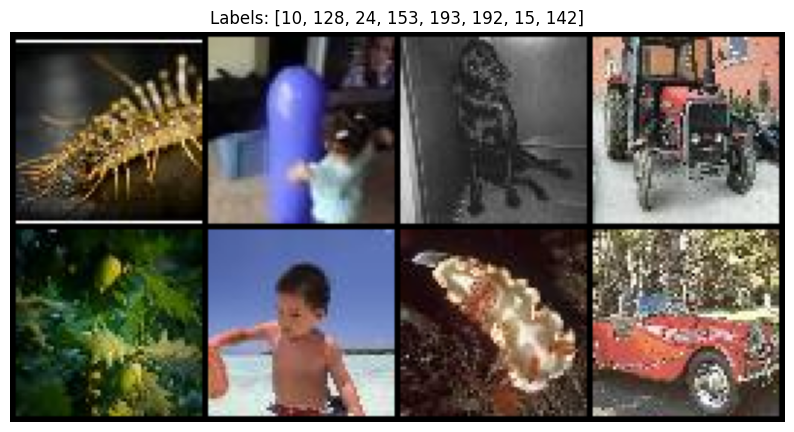

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def show_image_grid(image_tensor, labels, num_images):
    # 取消归一化
    image_tensor = torch.stack([unnormalize(img) for img in image_tensor])
    
    # 使用 make_grid 生成图像网格
    grid_img = torchvision.utils.make_grid(image_tensor, nrow=num_images//2)

    # 转换为 NumPy 格式并显示
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.title(f'Labels: {labels.tolist()}')
    plt.axis('off')
    plt.show()
    
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
data_iter = iter(train_loader)
batch = next(data_iter)
images, labels = batch['image'], batch['label']

# 可视化前 8 张图像
show_image_grid(images, labels, num_images=8)

### VGG

VGG网络是由牛津大学计算机视觉组和谷歌DeepMind团队共同提出的，在2014年的ImageNet挑战赛上表现非常出色。其最大的特点是使用了**非常深的网络结构**，而且网络中的卷积层只使用了3x3的小卷积核，保持了简单而一致的设计原则。VGG 网络有多个变种，其中最常用的是 **VGG-16** 和 **VGG-19**，数字表示网络中包含的层数。**VGG-16** 是 VGG 网络中最经典的结构之一，包含 13 个卷积层和 3 个全连接层，总共 16 层。这种深层结构可以提取出非常细致的特征，从而在分类任务中表现出色。
VGG-16 的网络结构可以分为多个卷积块（Convolutional Block），每个卷积块中包含多个卷积层，之后紧跟一个最大池化层来缩小特征图尺寸。以下是 VGG-16 的具体结构：

#### 卷积块 1
- **卷积层 1-1**: 64 个 3x3 卷积核，padding=1。
- **卷积层 1-2**: 64 个 3x3 卷积核，padding=1。
- **最大池化层 1**: 2x2, stride=2。

#### 卷积块 2
- **卷积层 2-1**: 128 个 3x3 卷积核，padding=1。
- **卷积层 2-2**: 128 个 3x3 卷积核，padding=1。
- **最大池化层 2**: 2x2, stride=2。

#### 卷积块 3
- **卷积层 3-1**: 256 个 3x3 卷积核，padding=1。
- **卷积层 3-2**: 256 个 3x3 卷积核，padding=1。
- **卷积层 3-3**: 256 个 3x3 卷积核，padding=1。
- **最大池化层 3**: 2x2, stride=2。

#### 卷积块 4
- **卷积层 4-1**: 512 个 3x3 卷积核，padding=1。
- **卷积层 4-2**: 512 个 3x3 卷积核，padding=1。
- **卷积层 4-3**: 512 个 3x3 卷积核，padding=1。
- **最大池化层 4**: 2x2, stride=2。

#### 卷积块 5
- **卷积层 5-1**: 512 个 3x3 卷积核，padding=1。
- **卷积层 5-2**: 512 个 3x3 卷积核，padding=1。
- **卷积层 5-3**: 512 个 3x3 卷积核，padding=1。
- **最大池化层 5**: 2x2, stride=2。

#### 全连接层
- **全连接层 1**: 输入为展平后的特征图（这里使用`self._init_fc_size()`自动计算），输出 4096 个神经元。
- **全连接层 2**: 4096 个神经元。
- **全连接层 3**: 1000 个神经元（ImageNet-1k 分类任务中有 1000 类）。

除最后一层使用SoftMax外，其余各层均使用ReLU激活函数。

#### Dropout
Dropout 是一种防止神经网络过拟合的正则化技术。在训练时，它以一定概率（如 50%）随机“丢弃”部分神经元，使网络在每次前向传播中只使用部分神经元，降低神经元之间的共适应性，增强模型的泛化能力。在 VGG-16 中，Dropout 被应用于全连接层部分，概率为 0.5，表示在训练时有 50% 的神经元被随机丢弃。由于全连接层参数较多，容易发生过拟合，Dropout 帮助减少这一问题。训练时随机丢弃神经元，测试时所有神经元保留。

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

CHANNELS1 = 64
CHANNELS2 = 128
CHANNELS3 = 256
CHANNELS4 = 512

class VGG16(nn.Module):
    def __init__(self, input_size:int=CHANNELS1, num_classes:int=200):
        super(VGG16, self).__init__()
        
        # VGG-16 的卷积层部分，加入Batch Normalization
        self.features = nn.Sequential(
            # 卷积块 1
            nn.Conv2d(3, CHANNELS1, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS1),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS1, CHANNELS1, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS1),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸减半
            
            # 卷积块 2
            nn.Conv2d(CHANNELS1, CHANNELS2, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS2),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS2, CHANNELS2, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS2),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸减半
            
            # 卷积块 3
            nn.Conv2d(CHANNELS2, CHANNELS3, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS3),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS3, CHANNELS3, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS3),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS3, CHANNELS3, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS3),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸减半
            
            # 卷积块 4
            nn.Conv2d(CHANNELS3, CHANNELS4, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS4),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS4, CHANNELS4, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS4),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS4, CHANNELS4, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS4),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸减半
            
            # 卷积块 5
            nn.Conv2d(CHANNELS4, CHANNELS4, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS4),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS4, CHANNELS4, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS4),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(CHANNELS4, CHANNELS4, kernel_size=3, padding=1),
            nn.BatchNorm2d(CHANNELS4),  # 加入Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 输出尺寸减半
        )
        
        # 动态计算特征图大小
        self._init_fc_size(input_size)

        # VGG-16 的全连接层部分
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)  # 输出为分类数
        )
        
        self.softmax = nn.Softmax(dim=1)
        
        torch.nn.init.kaiming_normal_(self.classifier[0].weight, nonlinearity='relu')
        
    def _init_fc_size(self, input_size):
        # 用一个假数据通过卷积层来计算最后的特征图大小
        dummy_input = torch.zeros(1, 3, input_size, input_size)
        dummy_output = self.features(dummy_input)
        self.flattened_size = dummy_output.numel()

    def forward(self, x) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def predict(self, x):
        logits = self.forward(x)
        probs = self.softmax(logits)
        return probs

### 训练
由于这是典型的分类问题，我们使用交叉熵损失：
$$ L = - \sum_{i} y_i \log(\hat{y}_i) $$
其中：
- $ y_i $ 是样本的真实标签。
- $ \hat{y}_i $ 是模型预测的类别概率。

在 PyTorch 中，交叉熵损失通过 `nn.CrossEntropyLoss()` 实现，该函数将 softmax 和负对数似然损失结合在一起，因此不需要手动添加 softmax 层。

In [11]:
import torch.nn as nn
import torch.optim as optim
from utils.train import train_model

model = VGG16(num_classes=200, input_size=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, train_dataset, val_dataset, 
            criterion_class=nn.CrossEntropyLoss,
            epochs=256, 
            learning_rate=1e-3, 
            batch_size=64,
            clip_grad_value=1.0,
            use_scheduler=True,
            )

Epoch 1/256: 100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


Val Loss: 5.0887, Val Acc: 1.20


Epoch 2/256: 100%|██████████| 1563/1563 [05:17<00:00,  4.93it/s]


Val Loss: 5.0599, Val Acc: 1.85


Epoch 3/256: 100%|██████████| 1563/1563 [05:17<00:00,  4.93it/s]


Val Loss: 4.6787, Val Acc: 3.45


Epoch 4/256: 100%|██████████| 1563/1563 [05:14<00:00,  4.97it/s]


Val Loss: 4.3987, Val Acc: 6.04


Epoch 5/256: 100%|██████████| 1563/1563 [05:13<00:00,  4.98it/s]


Val Loss: 4.2775, Val Acc: 7.47


Epoch 6/256: 100%|██████████| 1563/1563 [05:12<00:00,  5.00it/s]


Val Loss: 4.0896, Val Acc: 9.39


Epoch 7/256: 100%|██████████| 1563/1563 [05:13<00:00,  4.98it/s]


Val Loss: 3.9541, Val Acc: 11.54


Epoch 8/256: 100%|██████████| 1563/1563 [05:14<00:00,  4.96it/s]


Val Loss: 3.8202, Val Acc: 13.26


Epoch 9/256: 100%|██████████| 1563/1563 [05:13<00:00,  4.99it/s]


Val Loss: 3.7207, Val Acc: 14.93


Epoch 10/256: 100%|██████████| 1563/1563 [05:12<00:00,  5.00it/s]


Val Loss: 3.6603, Val Acc: 15.21


Epoch 11/256: 100%|██████████| 1563/1563 [05:14<00:00,  4.97it/s]


Val Loss: 3.5907, Val Acc: 17.06


Epoch 12/256: 100%|██████████| 1563/1563 [05:15<00:00,  4.95it/s]


Val Loss: 3.5033, Val Acc: 18.79


Epoch 13/256: 100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s]


Val Loss: 3.4606, Val Acc: 18.95


Epoch 14/256: 100%|██████████| 1563/1563 [05:17<00:00,  4.92it/s]


Val Loss: 3.6477, Val Acc: 16.81


Epoch 15/256: 100%|██████████| 1563/1563 [05:24<00:00,  4.81it/s]


Val Loss: 3.3206, Val Acc: 21.66


Epoch 16/256: 100%|██████████| 1563/1563 [05:05<00:00,  5.11it/s]


Val Loss: 3.2807, Val Acc: 22.76


Epoch 17/256: 100%|██████████| 1563/1563 [05:06<00:00,  5.09it/s]


Val Loss: 3.2638, Val Acc: 23.04


Epoch 18/256: 100%|██████████| 1563/1563 [05:03<00:00,  5.15it/s]


Val Loss: 3.2865, Val Acc: 22.56


Epoch 19/256: 100%|██████████| 1563/1563 [05:01<00:00,  5.18it/s]


Val Loss: 3.3681, Val Acc: 21.81


Epoch 20/256: 100%|██████████| 1563/1563 [05:01<00:00,  5.18it/s]


Val Loss: 3.2066, Val Acc: 24.39


Epoch 21/256: 100%|██████████| 1563/1563 [05:32<00:00,  4.70it/s]


Val Loss: 3.0876, Val Acc: 26.04


Epoch 22/256: 100%|██████████| 1563/1563 [06:13<00:00,  4.19it/s]


Val Loss: 3.0225, Val Acc: 27.74


Epoch 23/256: 100%|██████████| 1563/1563 [06:14<00:00,  4.18it/s]


Val Loss: 3.0321, Val Acc: 27.68


Epoch 24/256: 100%|██████████| 1563/1563 [05:24<00:00,  4.81it/s]


Val Loss: 2.9773, Val Acc: 28.99


Epoch 25/256: 100%|██████████| 1563/1563 [05:27<00:00,  4.77it/s]


Val Loss: 2.9069, Val Acc: 30.51


Epoch 26/256: 100%|██████████| 1563/1563 [05:14<00:00,  4.97it/s]


Val Loss: 2.9592, Val Acc: 29.66


Epoch 27/256: 100%|██████████| 1563/1563 [05:03<00:00,  5.16it/s]


Val Loss: 2.9212, Val Acc: 30.85


Epoch 28/256: 100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


Val Loss: 2.8953, Val Acc: 31.14


Epoch 29/256: 100%|██████████| 1563/1563 [05:14<00:00,  4.97it/s]


Val Loss: 2.9207, Val Acc: 30.61


Epoch 30/256: 100%|██████████| 1563/1563 [05:28<00:00,  4.76it/s]


Val Loss: 2.9641, Val Acc: 30.24


Epoch 31/256: 100%|██████████| 1563/1563 [05:15<00:00,  4.96it/s]


Val Loss: 2.8468, Val Acc: 31.85


Epoch 32/256: 100%|██████████| 1563/1563 [05:08<00:00,  5.06it/s]


Val Loss: 2.8798, Val Acc: 32.09


Epoch 33/256: 100%|██████████| 1563/1563 [05:01<00:00,  5.18it/s]


Val Loss: 2.9215, Val Acc: 31.43


Epoch 34/256: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s]


Val Loss: 3.5514, Val Acc: 23.06


Epoch 35/256: 100%|██████████| 1563/1563 [04:56<00:00,  5.27it/s]


Val Loss: 2.8870, Val Acc: 33.14


Epoch 36/256: 100%|██████████| 1563/1563 [04:57<00:00,  5.25it/s]


Val Loss: 2.9180, Val Acc: 32.74


Epoch 37/256: 100%|██████████| 1563/1563 [04:57<00:00,  5.26it/s]


Val Loss: 2.9623, Val Acc: 31.81


Epoch 38/256: 100%|██████████| 1563/1563 [04:56<00:00,  5.27it/s]


Val Loss: 2.8057, Val Acc: 35.60


Epoch 39/256: 100%|██████████| 1563/1563 [05:02<00:00,  5.16it/s]


Val Loss: 2.8045, Val Acc: 35.92


Epoch 40/256: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s]


Val Loss: 2.8284, Val Acc: 35.75


Epoch 41/256: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s]


Val Loss: 2.8749, Val Acc: 36.24


Epoch 42/256: 100%|██████████| 1563/1563 [05:03<00:00,  5.15it/s]


Val Loss: 2.8945, Val Acc: 35.89


Epoch 43/256: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s]


Val Loss: 2.9017, Val Acc: 36.09


Epoch 44/256: 100%|██████████| 1563/1563 [05:05<00:00,  5.12it/s]


Val Loss: 2.9332, Val Acc: 36.50


Epoch 45/256: 100%|██████████| 1563/1563 [05:10<00:00,  5.04it/s]


Val Loss: 2.9734, Val Acc: 35.95


Epoch 46/256: 100%|██████████| 1563/1563 [05:12<00:00,  4.99it/s]


Val Loss: 3.0050, Val Acc: 35.46


Epoch 47/256: 100%|██████████| 1563/1563 [05:15<00:00,  4.95it/s]


Val Loss: 2.9919, Val Acc: 36.04


Epoch 48/256: 100%|██████████| 1563/1563 [05:22<00:00,  4.84it/s]


Val Loss: 2.9791, Val Acc: 36.41


Epoch 49/256: 100%|██████████| 1563/1563 [05:00<00:00,  5.20it/s]


Val Loss: 3.0099, Val Acc: 36.08


Epoch 50/256: 100%|██████████| 1563/1563 [05:01<00:00,  5.19it/s]


Val Loss: 3.0142, Val Acc: 35.99


Epoch 51/256: 100%|██████████| 1563/1563 [05:04<00:00,  5.14it/s]


Val Loss: 3.0043, Val Acc: 36.15


Epoch 52/256: 100%|██████████| 1563/1563 [05:04<00:00,  5.13it/s]


Val Loss: 3.0123, Val Acc: 36.31


Epoch 53/256: 100%|██████████| 1563/1563 [05:17<00:00,  4.92it/s]


Val Loss: 3.0126, Val Acc: 36.14


Epoch 54/256: 100%|██████████| 1563/1563 [05:00<00:00,  5.20it/s]


Val Loss: 3.0199, Val Acc: 35.99


Epoch 55/256: 100%|██████████| 1563/1563 [04:56<00:00,  5.26it/s]


Val Loss: 2.9945, Val Acc: 36.48


Epoch 56/256: 100%|██████████| 1563/1563 [05:02<00:00,  5.17it/s]


Val Loss: 3.0134, Val Acc: 36.01


Epoch 57/256: 100%|██████████| 1563/1563 [05:11<00:00,  5.02it/s]


Val Loss: 3.0060, Val Acc: 36.26


Epoch 58/256: 100%|██████████| 1563/1563 [05:09<00:00,  5.05it/s]


Val Loss: 3.0198, Val Acc: 35.74


Epoch 59/256: 100%|██████████| 1563/1563 [05:07<00:00,  5.09it/s]


Val Loss: 3.0179, Val Acc: 35.95


Epoch 60/256: 100%|██████████| 1563/1563 [05:09<00:00,  5.05it/s]


Val Loss: 3.0104, Val Acc: 36.00


Epoch 61/256: 100%|██████████| 1563/1563 [05:11<00:00,  5.02it/s]


Val Loss: 3.0145, Val Acc: 36.14


Epoch 62/256: 100%|██████████| 1563/1563 [05:12<00:00,  5.01it/s]


Val Loss: 2.9948, Val Acc: 36.14


Epoch 63/256: 100%|██████████| 1563/1563 [05:11<00:00,  5.02it/s]


Val Loss: 3.0091, Val Acc: 35.94


Epoch 64/256: 100%|██████████| 1563/1563 [05:07<00:00,  5.08it/s]


Val Loss: 3.0171, Val Acc: 36.15


Epoch 65/256: 100%|██████████| 1563/1563 [05:09<00:00,  5.05it/s]


Val Loss: 3.0142, Val Acc: 36.42


Epoch 66/256: 100%|██████████| 1563/1563 [05:11<00:00,  5.01it/s]


Val Loss: 3.0112, Val Acc: 36.33


Epoch 67/256: 100%|██████████| 1563/1563 [05:10<00:00,  5.03it/s]


Val Loss: 3.0018, Val Acc: 36.41


Epoch 68/256: 100%|██████████| 1563/1563 [05:09<00:00,  5.06it/s]


Val Loss: 2.9985, Val Acc: 36.27


Epoch 69/256: 100%|██████████| 1563/1563 [05:10<00:00,  5.03it/s]


Val Loss: 2.9991, Val Acc: 36.36


Epoch 70/256: 100%|██████████| 1563/1563 [05:55<00:00,  4.40it/s]


Val Loss: 3.0139, Val Acc: 36.10


Epoch 71/256:  81%|████████  | 1260/1563 [04:25<01:03,  4.75it/s]


KeyboardInterrupt: 

In [9]:
torch.save(model, 'a.pth')

显示loss和accu曲线

可以看到，loss和accu的形状都很正常，说明模型按照预期收敛；而train和valid的值差异不是太大，说明没有发生明显的过拟合。

保存训练好的模型参数

### 测试模型效果
编写测试函数

In [27]:
def test_model(model, test_dataset, 
               criterion=nn.MSELoss(), 
               batch_size=32,
               device=torch.device('cpu')):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return avg_test_loss, test_accuracy

测试模型

In [ ]:
model = MyLeNet()
model.load_state_dict(torch.load(os.path.join("models", "model_2024-09-07_23-56-41.pth"), weights_only=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss, acc = test_model(model, test_dataset, criterion=criterion, batch_size=64, device=device)

模型准确率达到98.77%，效果很不错。